## Loading Trained Models and Data

In [51]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.nn import functional as F
import imutils
import cv2

In [76]:
# Loading data from MNIST and grabbing N data points
N = 10
test_data = MNIST(root='data', train=False, download=True, transform=ToTensor())
indxs = np.random.choice(range(len(test_data)), size=(N,))
test_data = Subset(test_data, indxs)

# Initializing test data loader
test_data_loader = DataLoader(test_data, batch_size=1)

In [13]:
# Loading our saved models
# the following abbreviations are used throughout:
# freq -> normal LeNet
# bayes -> bayesian version of LeNet

freq_path = 'output/freq_model.pth'
bayes_path = 'output/bayesian_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

freq_model = torch.load(freq_path).to(device)
bayes_model = torch.load(bayes_path).to(device)

freq_model.eval()
bayes_model.eval()

;

''

## Making Predictions

In [21]:
pictures = []

In [45]:
# let's make a batch of predictions for the frequentist model
# after we write this explicitly, there should be some parts we 
# can make into their own functions

torch.no_grad()

trail_no = 0

for (img, label) in test_data_loader:
    trial_no += 1

    # getting original img and interpreting the label
    original_img = img.numpy().squeeze(axis=(0,1))
    ground_truth_label = test_data.dataset.classes[label.numpy()[0]]

    #pictures.append(original_img)
    
    network_output = freq_model(img)
    prediction = torch.mean(network_output, dim=0).cpu().detach().numpy()
    predicted_indx = prediction.argmax(axis=0)
    predicted_label = test_data.dataset.classes[predicted_indx]
    
    color = (0, 255, 0) if ground_truth_label == predicted_label else (0, 0, 255)
    original_img = np.dstack([original_img] * 3)
    original_img = imutils.resize(original_img, width=128)
    original_img = cv2.putText(original_img, ground_truth_label, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
    #text_summary = "Trial: {}\n Ground truth label: {}, predicted label: {}\n".format(trial_no, ground_truth_label, predicted_label)
    
    cv2.imwrite('test_output.png', original_img*255)
    #display(Image(filename='test_output.png'))
    
    
    
    


In [39]:
# function: get pred for single model/image
# function: make prediction grid(n)
# function: get pred and uncertainties for a single model/image
# function: get p_hat from network out
# function: display pred's and uc's 

In [35]:
from IPython.display import Image, display


original_img = pictures[0]
original_img = np.dstack([original_img] * 3)
original_img = imutils.resize(original_img, width=128)

cv2.imwrite('test_output.png', original_img*255)

#display(Image(filename='test_output.png'))

True

Trial: 91
 Ground truth label: 9 - nine, predicted label: 9 - nine
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


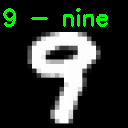

Trial: 92
 Ground truth label: 2 - two, predicted label: 2 - two
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


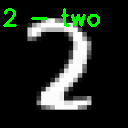

Trial: 93
 Ground truth label: 2 - two, predicted label: 2 - two
 uncertainty from model: 3.552713678800501e-15
uncertainty from data: 0.0
total uncertainty: 3.552713678800501e-15


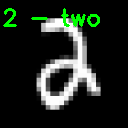

Trial: 94
 Ground truth label: 7 - seven, predicted label: 7 - seven
 uncertainty from model: 5.684341886080802e-14
uncertainty from data: 7.152557373046875e-07
total uncertainty: 7.152557373046897e-07


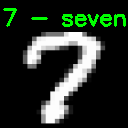

Trial: 95
 Ground truth label: 7 - seven, predicted label: 7 - seven
 uncertainty from model: 1.4210854715202004e-14
uncertainty from data: 0.00030666589736938477
total uncertainty: 0.00030666589736938477


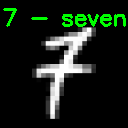

In [56]:
# bayes model + trying to calculate uncertainties

torch.no_grad()

trail_no = 0
T = 15

for (img, label) in test_data_loader:
    trial_no += 1

    # getting original img and interpreting the label
    original_img = img.numpy().squeeze(axis=(0,1))
    ground_truth_label = test_data.dataset.classes[label.numpy()[0]]
    
    input_image = img.unsqueeze(0)
    input_images = img.repeat(T, 1, 1, 1)

    network_output = bayes_model(input_images)
    prediction = torch.mean(network_output, dim=0).cpu().detach().numpy()
    predicted_indx = prediction.argmax(axis=0)
    predicted_label = test_data.dataset.classes[predicted_indx]
    
    
    # getting uncertainties
    normalized = False
    if normalized:
        pred = F.softplus(network_output)
        p_hat = pred / torch.sum(pred, dim=1).unsqueeze(1)
    else:
        p_hat = F.softmax(network_output, dim=1)
    p_hat = p_hat.detach().cpu().numpy()
    p_bar = np.mean(p_hat, axis=0)
    
    temp = p_hat - np.expand_dims(p_bar, 0)
    epistemic_ucs = np.dot(temp.T, temp) / T
    epistemic_ucs = np.diag(epistemic_ucs)

    aleatoric_ucs = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
    aleatoric_ucs = np.diag(aleatoric_ucs)
    
    epistemic = epistemic_ucs[predicted_indx]
    aleatoric = aleatoric_ucs[predicted_indx]
    total_uncertainty = np.sqrt(epistemic**2 + aleatoric**2)
    
    
    color = (0, 255, 0) if ground_truth_label == predicted_label else (0, 0, 255)
    original_img = np.dstack([original_img] * 3)
    original_img = imutils.resize(original_img, width=128)
    original_img = cv2.putText(original_img, ground_truth_label, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
    text_summary = "Trial: {}\n Ground truth label: {}, predicted label: {}\n".format(trial_no, ground_truth_label, predicted_label)
    uncertainty_annotation = "uncertainty from model: {}\nuncertainty from data: {}\ntotal uncertainty: {}".format(epistemic, aleatoric, total_uncertainty)
    
    
    print(text_summary, uncertainty_annotation)
    cv2.imwrite('test_output.png', original_img*255)
    display(Image(filename='test_output.png'))

In [61]:
import sys
!{sys.executable} -m pip install PrettyTable

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [62]:
from prettytable import PrettyTable

In [79]:
def make_bayes_image(img, label, i=0):
    with torch.no_grad():
        # getting original img and interpreting the label
        original_img = img.numpy().squeeze(axis=(0,1))
        ground_truth_label = test_data.dataset.classes[label.numpy()[0]]

        input_image = img.unsqueeze(0)
        input_images = img.repeat(T, 1, 1, 1)

        network_output = bayes_model(input_images)
        prediction = torch.mean(network_output, dim=0).cpu().detach().numpy()
        predicted_indx = prediction.argmax(axis=0)
        predicted_label = test_data.dataset.classes[predicted_indx]


        # getting uncertainties
        normalized = False
        if normalized:
            pred = F.softplus(network_output)
            p_hat = pred / torch.sum(pred, dim=1).unsqueeze(1)
        else:
            p_hat = F.softmax(network_output, dim=1)
        p_hat = p_hat.detach().cpu().numpy()
        p_bar = np.mean(p_hat, axis=0)

        temp = p_hat - np.expand_dims(p_bar, 0)
        epistemic_ucs = np.dot(temp.T, temp) / T
        epistemic_ucs = np.diag(epistemic_ucs)

        aleatoric_ucs = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
        aleatoric_ucs = np.diag(aleatoric_ucs)

        epistemic = epistemic_ucs[predicted_indx]
        aleatoric = aleatoric_ucs[predicted_indx]
        total_uncertainty = np.sqrt(epistemic**2 + aleatoric**2)


        color = (0, 255, 0) if ground_truth_label == predicted_label else (0, 0, 255)
        original_img = np.dstack([original_img] * 3)
        original_img = imutils.resize(original_img, width=128)
        original_img = cv2.putText(original_img, ground_truth_label, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
        text_summary = "Trial: {}\n Ground truth label: {}, predicted label: {}\n".format(trial_no, ground_truth_label, predicted_label)
        uncertainty_annotation = "uncertainty from model: {}\nuncertainty from data: {}\ntotal uncertainty: {}".format(epistemic, aleatoric, total_uncertainty)


        #print(text_summary, uncertainty_annotation)
        cv2.imwrite('bayes_image_{}.png'.format(i), original_img*255)
        display(Image(filename='bayes_image_{}.png'.format(i)))
        
        uc_table = PrettyTable()
        uc_table.add_column("Category", ['Ground Truth', 'Prediction', 'Epistemic Uncertainty', 'Aleatoric Uncertainty', 'Total Uncertainty'])
        uc_table.add_column("Result", [ground_truth_label, predicted_label, epistemic, aleatoric, total_uncertainty])
        print(uc_table.get_string())

            
            

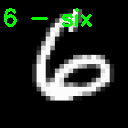

+-----------------------+---------+
|        Category       |  Result |
+-----------------------+---------+
|      Ground Truth     | 6 - six |
|       Prediction      | 6 - six |
| Epistemic Uncertainty |   0.0   |
| Aleatoric Uncertainty |   0.0   |
|   Total Uncertainty   |   0.0   |
+-----------------------+---------+


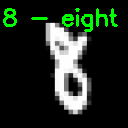

+-----------------------+-----------------------+
|        Category       |         Result        |
+-----------------------+-----------------------+
|      Ground Truth     |       8 - eight       |
|       Prediction      |       8 - eight       |
| Epistemic Uncertainty |     3.5527137e-15     |
| Aleatoric Uncertainty |     5.6028366e-06     |
|   Total Uncertainty   | 5.602836608886719e-06 |
+-----------------------+-----------------------+


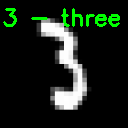

+-----------------------+-----------------------+
|        Category       |         Result        |
+-----------------------+-----------------------+
|      Ground Truth     |       3 - three       |
|       Prediction      |       3 - three       |
| Epistemic Uncertainty |      5.684342e-14     |
| Aleatoric Uncertainty |     7.1525574e-07     |
|   Total Uncertainty   | 7.152557373046897e-07 |
+-----------------------+-----------------------+


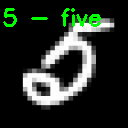

+-----------------------+---------------------+
|        Category       |        Result       |
+-----------------------+---------------------+
|      Ground Truth     |       5 - five      |
|       Prediction      |       5 - five      |
| Epistemic Uncertainty |    3.1974423e-14    |
| Aleatoric Uncertainty |     0.043364227     |
|   Total Uncertainty   | 0.04336422681808472 |
+-----------------------+---------------------+


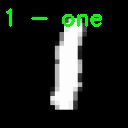

+-----------------------+---------------------+
|        Category       |        Result       |
+-----------------------+---------------------+
|      Ground Truth     |       1 - one       |
|       Prediction      |       1 - one       |
| Epistemic Uncertainty |         0.0         |
| Aleatoric Uncertainty |     4.196167e-05    |
|   Total Uncertainty   | 4.1961669921875e-05 |
+-----------------------+---------------------+


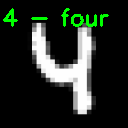

+-----------------------+----------+
|        Category       |  Result  |
+-----------------------+----------+
|      Ground Truth     | 4 - four |
|       Prediction      | 4 - four |
| Epistemic Uncertainty |   0.0    |
| Aleatoric Uncertainty |   0.0    |
|   Total Uncertainty   |   0.0    |
+-----------------------+----------+


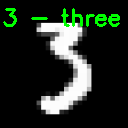

+-----------------------+---------------------+
|        Category       |        Result       |
+-----------------------+---------------------+
|      Ground Truth     |      3 - three      |
|       Prediction      |      3 - three      |
| Epistemic Uncertainty |         0.0         |
| Aleatoric Uncertainty |     9.536743e-07    |
|   Total Uncertainty   | 9.5367431640625e-07 |
+-----------------------+---------------------+


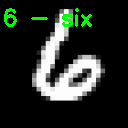

+-----------------------+---------+
|        Category       |  Result |
+-----------------------+---------+
|      Ground Truth     | 6 - six |
|       Prediction      | 6 - six |
| Epistemic Uncertainty |   0.0   |
| Aleatoric Uncertainty |   0.0   |
|   Total Uncertainty   |   0.0   |
+-----------------------+---------+


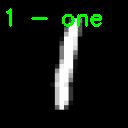

+-----------------------+------------------------+
|        Category       |         Result         |
+-----------------------+------------------------+
|      Ground Truth     |        1 - one         |
|       Prediction      |        1 - one         |
| Epistemic Uncertainty |     1.4210855e-14      |
| Aleatoric Uncertainty |     2.4437904e-06      |
|   Total Uncertainty   | 2.4437904357910156e-06 |
+-----------------------+------------------------+


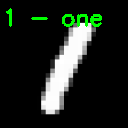

+-----------------------+----------------------+
|        Category       |        Result        |
+-----------------------+----------------------+
|      Ground Truth     |       1 - one        |
|       Prediction      |       1 - one        |
| Epistemic Uncertainty |         0.0          |
| Aleatoric Uncertainty |    0.00012588501     |
|   Total Uncertainty   | 0.000125885009765625 |
+-----------------------+----------------------+


In [80]:
i = 0
for (img, label) in test_data_loader:
    i += 1
    make_bayes_image(img, label, i=i)